# MIMIC-IV Stay-Level EDA

This notebook performs exploratory data analysis on MIMIC-IV 3.1 at the **ICU stay** granularity.

## Goals
- Count unique patients and ICU stays
- Capture key clinical outcomes as boolean flags per stay:
  - **Death** (in-hospital and in-ICU)
  - **Sepsis** (Sepsis-3 criteria)
  - **Mechanical ventilation**
  - **CRRT** (Continuous Renal Replacement Therapy / kidney failure)
- Cache results locally to avoid repeat BigQuery costs

## Data Source
- BigQuery: `physionet-data.mimiciv_3_1_*` tables
- Primary table: `mimiciv_3_1_derived.icustay_detail` (~94k ICU stays)

## 1. Setup

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.cloud import bigquery

# Configuration
PROJECT_ID = "icu-project-486401"  # Update with your GCP project ID
DATA_DIR = Path("../data")
CACHE_FILE = DATA_DIR / "stay_summary.parquet"

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Ensure data directory exists
DATA_DIR.mkdir(exist_ok=True)

print(f"Cache file: {CACHE_FILE}")
print(f"Cache exists: {CACHE_FILE.exists()}")

Cache file: ../data/stay_summary.parquet
Cache exists: False


## 2. Data Retrieval

Single consolidated query to get stay-level summary with outcome flags.
Uses caching to avoid repeat BigQuery costs.

In [5]:
# Stay-level summary query with outcome flags
STAY_SUMMARY_QUERY = """
SELECT 
    i.subject_id,
    i.hadm_id,
    i.stay_id,
    i.gender,
    i.admission_age,
    i.race,
    i.los_icu,
    i.los_hospital,
    i.icu_intime,
    i.icu_outtime,
    i.hospstay_seq,
    i.icustay_seq,
    
    -- Death outcomes
    i.hospital_expire_flag,
    CASE WHEN a.deathtime BETWEEN i.icu_intime AND i.icu_outtime THEN 1 ELSE 0 END AS death_in_icu,
    
    -- Sepsis (Sepsis-3 criteria)
    CASE WHEN s.stay_id IS NOT NULL THEN 1 ELSE 0 END AS sepsis,
    
    -- Mechanical ventilation
    CASE WHEN v.stay_id IS NOT NULL THEN 1 ELSE 0 END AS ventilation,
    
    -- CRRT (Continuous Renal Replacement Therapy - indicates acute kidney injury)
    CASE WHEN cr.stay_id IS NOT NULL THEN 1 ELSE 0 END AS crrt

FROM `physionet-data.mimiciv_3_1_derived.icustay_detail` i
LEFT JOIN `physionet-data.mimiciv_3_1_hosp.admissions` a 
    ON i.hadm_id = a.hadm_id
LEFT JOIN (
    SELECT DISTINCT stay_id 
    FROM `physionet-data.mimiciv_3_1_derived.sepsis3`
) s ON i.stay_id = s.stay_id
LEFT JOIN (
    SELECT DISTINCT stay_id 
    FROM `physionet-data.mimiciv_3_1_derived.ventilation`
) v ON i.stay_id = v.stay_id
LEFT JOIN (
    SELECT DISTINCT stay_id 
    FROM `physionet-data.mimiciv_3_1_derived.crrt`
) cr ON i.stay_id = cr.stay_id

ORDER BY i.subject_id, i.stay_id
"""

def load_stay_summary(force_refresh=False):
    """Load stay summary from cache or BigQuery."""
    if CACHE_FILE.exists() and not force_refresh:
        print(f"Loading from cache: {CACHE_FILE}")
        df = pd.read_parquet(CACHE_FILE)
        print(f"Loaded {len(df):,} rows from cache")
        return df
    
    print("Querying BigQuery (this may take a moment)...")
    client = bigquery.Client(project=PROJECT_ID)
    df = client.query(STAY_SUMMARY_QUERY).to_dataframe()
    
    # Save to cache
    df.to_parquet(CACHE_FILE, index=False)
    print(f"Saved {len(df):,} rows to {CACHE_FILE}")
    
    return df

In [6]:
# Load the data (from cache if available, otherwise query BigQuery)
df = load_stay_summary(force_refresh=False)
df.head()

Querying BigQuery (this may take a moment)...


/Users/daviderf/opt/anaconda3/lib/python3.9/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Saved 94,458 rows to ../data/stay_summary.parquet


,subject_id,hadm_id,stay_id,gender,admission_age,race,los_icu,los_hospital,icu_intime,icu_outtime,hospstay_seq,icustay_seq,hospital_expire_flag,death_in_icu,sepsis,ventilation,crrt
0,10000032,29079034,39553978,F,52,WHITE,0.380000000,2,2180-07-23 14:00:00,2180-07-23 23:50:47,1,1,0,0,0,1,0
1,10000690,25860671,37081114,F,86,WHITE,3.920000000,10,2150-11-02 19:37:00,2150-11-06 17:03:17,1,1,0,0,0,1,0
2,10000980,26913865,39765666,F,76,BLACK/AFRICAN AMERICAN,0.500000000,6,2189-06-27 08:42:00,2189-06-27 20:38:27,1,1,0,0,0,0,0
3,10001217,27703517,34592300,F,55,WHITE,0.960000000,6,2157-12-19 15:42:24,2157-12-20 14:27:41,2,1,0,0,0,0,0
4,10001217,24597018,37067082,F,55,WHITE,1.130000000,7,2157-11-20 19:18:02,2157-11-21 22:08:00,1,1,0,0,0,1,0


## 3. Basic Counts

In [8]:
n_stays = len(df)
n_patients = df['subject_id'].nunique()
n_admissions = df['hadm_id'].nunique()

print("=" * 50)
print("MIMIC-IV 3.1 Summary Statistics")
print("=" * 50)
print(f"Total ICU stays:        {n_stays:,}")
print(f"Unique patients:        {n_patients:,}")
print(f"Hospital admissions:    {n_admissions:,}")
print(f"Avg stays per patient:  {n_stays / n_patients:.2f}")
print("=" * 50)

MIMIC-IV 3.1 Summary Statistics
Total ICU stays:        94,458
Unique patients:        65,366
Hospital admissions:    85,242
Avg stays per patient:  1.45


In [9]:
# Distribution of ICU stays per patient
stays_per_patient = df.groupby('subject_id').size()
print("ICU stays per patient distribution:")
print(stays_per_patient.describe())

# How many patients have multiple ICU stays?
multi_stay_patients = (stays_per_patient > 1).sum()
print(f"\nPatients with multiple ICU stays: {multi_stay_patients:,} ({100*multi_stay_patients/n_patients:.1f}%)")

ICU stays per patient distribution:
count    65366.000000
mean         1.445063
std          1.169909
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         41.000000
dtype: float64

Patients with multiple ICU stays: 16,242 (24.8%)


## 4. Outcome Prevalence

Key clinical outcomes at the ICU stay level.

In [10]:
# Calculate outcome rates
outcomes = {
    'Hospital Death': df['hospital_expire_flag'].sum(),
    'ICU Death': df['death_in_icu'].sum(),
    'Sepsis (Sepsis-3)': df['sepsis'].sum(),
    'Mechanical Ventilation': df['ventilation'].sum(),
    'CRRT (Kidney Failure)': df['crrt'].sum()
}

print("=" * 60)
print("Outcome Prevalence (per ICU stay)")
print("=" * 60)
for outcome, count in outcomes.items():
    pct = 100 * count / n_stays
    print(f"{outcome:25s}: {count:>7,} stays ({pct:5.1f}%)")
print("=" * 60)

Outcome Prevalence (per ICU stay)
Hospital Death           :  11,350 stays ( 12.0%)
ICU Death                :   7,329 stays (  7.8%)
Sepsis (Sepsis-3)        :  32,899 stays ( 34.8%)
Mechanical Ventilation   :  70,783 stays ( 74.9%)
CRRT (Kidney Failure)    :   3,597 stays (  3.8%)


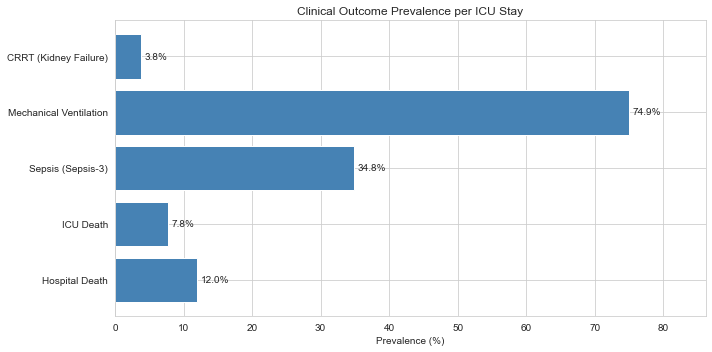

In [11]:
# Visualize outcome rates
outcome_rates = {k: 100 * v / n_stays for k, v in outcomes.items()}

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(list(outcome_rates.keys()), list(outcome_rates.values()), color='steelblue')
ax.set_xlabel('Prevalence (%)')
ax.set_title('Clinical Outcome Prevalence per ICU Stay')

# Add value labels
for bar, pct in zip(bars, outcome_rates.values()):
    ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
            f'{pct:.1f}%', va='center', fontsize=10)

ax.set_xlim(0, max(outcome_rates.values()) * 1.15)
plt.tight_layout()
plt.show()

## 5. Demographics

In [12]:
# Age distribution
print("Age at admission:")
print(df['admission_age'].describe())

# Gender distribution
print("\nGender distribution:")
print(df['gender'].value_counts())

Age at admission:
count      94458.0
mean     64.780527
std      16.739041
min           18.0
25%           55.0
50%           66.0
75%           77.0
max          103.0
Name: admission_age, dtype: Float64

Gender distribution:
gender
M    52875
F    41583
Name: count, dtype: int64


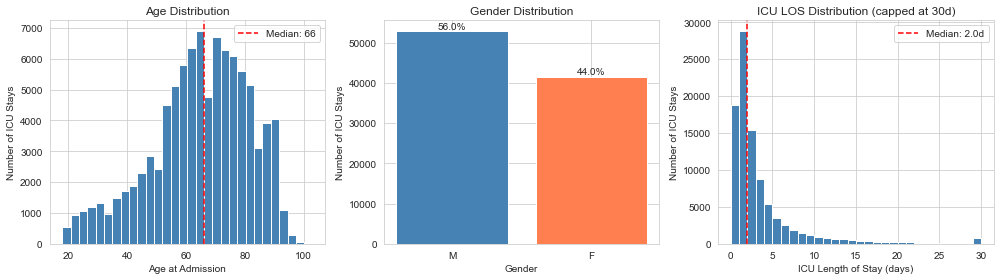

In [22]:
# Visualize demographics
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Age distribution
axes[0].hist(df['admission_age'], bins=30, edgecolor='white', color='steelblue')
axes[0].set_xlabel('Age at Admission')
axes[0].set_ylabel('Number of ICU Stays')
axes[0].set_title('Age Distribution')
axes[0].axvline(df['admission_age'].median(), color='red', linestyle='--', label=f"Median: {df['admission_age'].median():.0f}")
axes[0].legend()

# Gender distribution
gender_counts = df['gender'].value_counts()
axes[1].bar(gender_counts.index, gender_counts.values, color=['steelblue', 'coral'])
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Number of ICU Stays')
axes[1].set_title('Gender Distribution')
for i, (g, c) in enumerate(gender_counts.items()):
    axes[1].text(i, c + 500, f'{100*c/n_stays:.1f}%', ha='center')

# ICU Length of Stay distribution (capped at 30 days for visualization)
los_capped = df['los_icu'].clip(upper=30)
axes[2].hist(los_capped, bins=30, edgecolor='white', color='steelblue')
axes[2].set_xlabel('ICU Length of Stay (days)')
axes[2].set_ylabel('Number of ICU Stays')
axes[2].set_title('ICU LOS Distribution (capped at 30d)')
axes[2].axvline(df['los_icu'].median(), color='red', linestyle='--', label=f"Median: {df['los_icu'].median():.1f}d")
axes[2].legend()

plt.tight_layout()
plt.show()

Race/Ethnicity distribution:
race
WHITE                                        58888
BLACK/AFRICAN AMERICAN                        8677
UNKNOWN                                       8457
OTHER                                         3134
WHITE - OTHER EUROPEAN                        2310
UNABLE TO OBTAIN                              1881
HISPANIC/LATINO - PUERTO RICAN                1214
ASIAN                                         1095
ASIAN - CHINESE                               1062
WHITE - RUSSIAN                                980
HISPANIC OR LATINO                             783
HISPANIC/LATINO - DOMINICAN                    746
BLACK/CAPE VERDEAN                             656
BLACK/CARIBBEAN ISLAND                         621
PATIENT DECLINED TO ANSWER                     515
BLACK/AFRICAN                                  431
PORTUGUESE                                     425
ASIAN - SOUTH EAST ASIAN                       408
WHITE - EASTERN EUROPEAN                       2

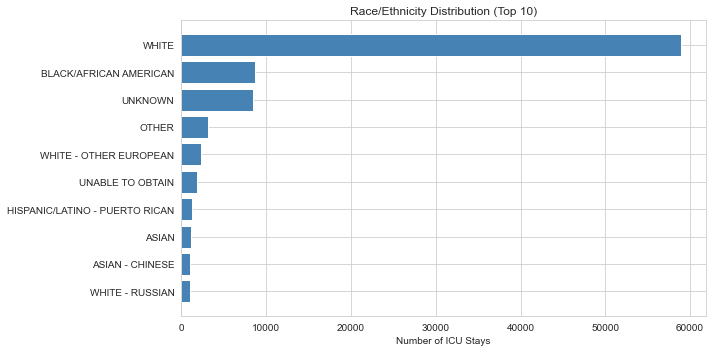

In [21]:
# Race/ethnicity distribution
print("Race/Ethnicity distribution:")
race_counts = df['race'].value_counts()
print(race_counts)

# Visualize top races
fig, ax = plt.subplots(figsize=(10, 5))
top_races = race_counts.head(10)
bars = ax.barh(top_races.index[::-1], top_races.values[::-1], color='steelblue')
ax.set_xlabel('Number of ICU Stays')
ax.set_title('Race/Ethnicity Distribution (Top 10)')
plt.tight_layout()
plt.show()

## 6. Data Summary

Overview of the cached dataset schema and storage.

In [15]:
# Data schema
print("Dataset Schema:")
print("-" * 60)
df.info()

# File size
if CACHE_FILE.exists():
    size_mb = CACHE_FILE.stat().st_size / (1024 * 1024)
    print(f"\nCache file size: {size_mb:.2f} MB")

Dataset Schema:
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94458 entries, 0 to 94457
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   subject_id            94458 non-null  Int64         
 1   hadm_id               94458 non-null  Int64         
 2   stay_id               94458 non-null  Int64         
 3   gender                94458 non-null  object        
 4   admission_age         94458 non-null  Int64         
 5   race                  94458 non-null  object        
 6   los_icu               94444 non-null  object        
 7   los_hospital          94458 non-null  Int64         
 8   icu_intime            94458 non-null  datetime64[us]
 9   icu_outtime           94444 non-null  datetime64[us]
 10  hospstay_seq          94458 non-null  Int64         
 11  icustay_seq           94458 non-null  Int64         
 1

## 7. Outcome Co-occurrence

How often do these clinical outcomes occur together?

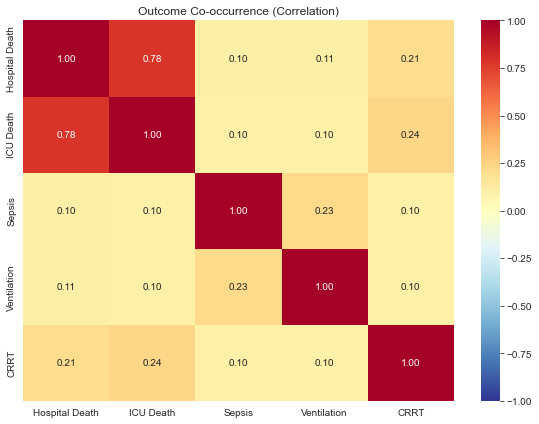

In [16]:
# Outcome co-occurrence matrix
outcome_cols = ['hospital_expire_flag', 'death_in_icu', 'sepsis', 'ventilation', 'crrt']
outcome_names = ['Hospital Death', 'ICU Death', 'Sepsis', 'Ventilation', 'CRRT']

# Calculate correlation matrix for binary outcomes
corr_matrix = df[outcome_cols].corr()
corr_matrix.index = outcome_names
corr_matrix.columns = outcome_names

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', 
            center=0, vmin=-1, vmax=1, ax=ax)
ax.set_title('Outcome Co-occurrence (Correlation)')
plt.tight_layout()
plt.show()

In [17]:
# Count stays by number of adverse outcomes
# (excluding hospital death since ICU death is a subset)
adverse_outcomes = ['death_in_icu', 'sepsis', 'ventilation', 'crrt']
df['n_adverse_outcomes'] = df[adverse_outcomes].sum(axis=1)

print("Distribution of adverse outcomes per stay:")
outcome_dist = df['n_adverse_outcomes'].value_counts().sort_index()
for n, count in outcome_dist.items():
    print(f"  {n} outcomes: {count:>6,} stays ({100*count/n_stays:5.1f}%)")

# Stays with at least one adverse outcome
any_adverse = (df['n_adverse_outcomes'] > 0).sum()
print(f"\nStays with >= 1 adverse outcome: {any_adverse:,} ({100*any_adverse/n_stays:.1f}%)")

Distribution of adverse outcomes per stay:
  0 outcomes: 19,114 stays ( 20.2%)
  1 outcomes: 42,306 stays ( 44.8%)
  2 outcomes: 27,640 stays ( 29.3%)
  3 outcomes:  4,570 stays (  4.8%)
  4 outcomes:    828 stays (  0.9%)

Stays with >= 1 adverse outcome: 75,344 (79.8%)
